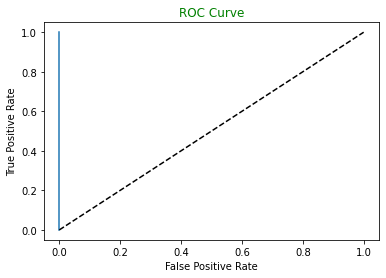

{'output_img_path': './static/download/face_recognition/1295833840917545_face_detection.png',
 'matching_case': 'Matched',
 'person_name': '00773'}

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
from random import randint


TRAIN_IMG_FOLDER = './static/images/training_data/'

width = 128
height = 128

train_image_names = os.listdir(TRAIN_IMG_FOLDER)
training_tensor = np.ndarray(
    shape=(len(train_image_names), height*width), dtype=np.float64)

for i in range(len(train_image_names)):
    img = cv2.imread((TRAIN_IMG_FOLDER + train_image_names[i]), 0)
    img = cv2.resize(img, dsize=(128, 128))
    training_tensor[i, :] = np.array(img, dtype='float64').flatten()


mean_face = np.mean(training_tensor)

mean_face = np.divide(mean_face, float(len(train_image_names))).flatten()


normalised_training_tensor = training_tensor-mean_face

cov_matrix = np.cov(normalised_training_tensor)

eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
k = 50
topk_indices = sorted_indices[:k]

reduced_eigenvectors = eigenvectors[:, topk_indices]

proj_data = np.dot(training_tensor.transpose(), reduced_eigenvectors)

proj_data = proj_data.transpose()

w = np.array([np.dot(proj_data, i) for i in normalised_training_tensor])

# print(w)


def Visualization(img_path, train_image_names=train_image_names, proj_data=proj_data, w=w, t0=3.7e7):
    # Load ground truth labels
    train_labels = [name.split('_')[0] for name in train_image_names]
    unknown_label = os.path.basename(img_path).split('_')[0]
    
    unknown_face = cv2.imread(img_path, 0)
    unknown_face = cv2.resize(unknown_face, dsize=(128, 128))
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector, mean_face)

    w_unknown = np.dot(proj_data, normalised_uface_vector)
    diff = w - w_unknown
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    my_dict = {'output_img_path': '', 'matching_case': '', 'person_name': ''}
    
    # Choose threshold value
    threshold = 0.5
    
    my_dict['output_img_path'] = f'./static/download/face_recognition/{randint(0,9999999999999999)}_face_detection.png'
    if norms[index] < t0:
        match = unknown_label == train_labels[index]
        if match:
            # True positive
            my_dict['matching_case'] = 'Matched'
            name, extension = os.path.splitext(train_image_names[index])
            plt.title(('Matched:  '+name), color='g')
        else:
            # False positive
            my_dict['matching_case'] = 'False matched'
            plt.title('False matched', color='r')

        out_img = (cv2.imread(TRAIN_IMG_FOLDER + train_image_names[index]))
        my_dict['person_name'] = train_image_names[index].split('_')[0]
        cv2.imwrite(my_dict['output_img_path'], out_img)

    else:
        # Unknown face
        my_dict['matching_case'] = 'Unknown face'
        plt.title('Unknown face', color='r')
    
    # Calculate false positive rate and true positive rate
    true_positives = 0
    false_positives = 0
    true_positives_total = sum([1 for label in train_labels if label == unknown_label])
    false_positives_total = sum([1 for label in train_labels if label != unknown_label])
    true_positive_rates = []
    false_positive_rates = []
    
    for i in range(len(norms)):
        if norms[i] < threshold:
            if train_labels[i] == unknown_label:
                true_positives += 1
            else:
                false_positives += 1
        
        true_positive_rate = true_positives / true_positives_total
        false_positive_rate = false_positives / false_positives_total
        true_positive_rates.append(true_positive_rate)
        false_positive_rates.append(false_positive_rate)
    
    # Plot ROC curve
    plt.plot(false_positive_rates, true_positive_rates)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    return my_dict


# front_data = Visualization('our_images_test/yasmin_16.jpg',
#                            train_image_names, proj_data, w, t0=2.7e7)
Visualization('./static/images/testing_data/00773_941201_fa.jpg')
# print(front_data)
